In [1]:
# %load blncq.py
import pygame
import torch

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
import os
from collections import deque

import IPython.display

print("OK")

pygame.init()

# Pygame screen size:
sx = 900
sy = 500

# Table hgitht, left brim, right brim...
tableH = sy-20
tableL = int(sx*0.1)
tableR = int(sx*0.9)

# Stick picture size:
stickL = 400
stickW = 50

cticker = pygame.time.Clock()
testsc = pygame.display.set_mode((sx, sy))

im_bg = pygame.image.load("../assets/bg.png").convert_alpha()
im_st = pygame.image.load("../assets/pp.png").convert_alpha()

im_bg = pygame.transform.scale(im_bg, (sx,sy))
im_st = pygame.transform.scale(im_st, (stickW, stickL))

# 
def get_bottom(img, th, bwidth = stickW):
    x = -img.get_rect()[2]
    y = -img.get_rect()[3]
    if np.sin(th)<0:
        x=0
    if np.cos(th)<0:
        y=0
    bx = np.sign(np.cos(th)) * np.abs(np.sin(th)) * bwidth/2
    by = np.sign(np.sin(th)) * np.abs(np.cos(th)) * bwidth/2
    return (x+by, y+bx)

#for i in range(1300):
#     testsc.blit(im_bg, (0,0))
#     tst = pygame.transform.rotate(im_st, i)
#     x,y = get_bottom(tst, i*np.pi/180)
#     testsc.blit(tst, (500+x,300+y))
#     # testsc.blit(im_bd, (300,500))
#     # print(tst.get_rect(),(x,y))
#     pygame.display.update()
#     cticker.tick(30)
    


class gameState():
    def __init__(self, th,w, x, v, g=1, zhuanguan=10):
        self.th = th
        self.w = w
        self.x = x
        self.v = v
        self.g = g
        self.guanliang = zhuanguan

    def forward(self, dv, disp = 0):
        self.v += dv
        self.x += self.v
        self.w +=  ( dv * np.cos(self.th*np.pi/180) + self.g * np.sin(self.th*np.pi/180))/self.guanliang
        self.th += self.w
        
        if disp == 1:
            one_frame = self.drawgame()
        else:
            one_frame = []

        ##
        stateLabel = 1
        if self.x < tableL or self.x > tableR or self.th < -90 or self.th > 90:
            stateLabel = 0
        ##
        return np.stack((self.th, self.w, self.x, self.v), axis=0), stateLabel, one_frame
    
    def drawgame(self):
        testsc.blit(im_bg, (0, 0))
        tst = pygame.transform.rotate(im_st, self.th)
        x,y = get_bottom(tst, self.th*np.pi/180)
        testsc.blit(tst, (self.x + x, tableH + y))
        pygame.display.update()
        cticker.tick(30)
        return pygame.surfarray.array3d(pygame.display.get_surface())

    def printgame(self):
        print("Theta:%s, w: %s, position_x: %s, v: %s" % (self.th, self.w, self.x, self.v))
    ##

    def plotgame(self, fig, img):
        IPython.display.clear_output(wait=True)
        img.set_data(image_data)
        IPython.display.display(fig)
        cticker.tick(30)

    def getState(self):
        return np.stack((self.th, self.w, self.x, self.v) , axis=0)

    def gameinit(self):
        self.th = (np.random.rand()-0.5)*10
        self.w = 0.0
        self.x = np.random.choice(range(tableL+100, tableR-100))
        self.v = np.random.rand()-0.5
        

game = gameState(1.0,0.0,400.0,0.0)

# for i in range(200):
#     x,s = game.forward(np.random.rand()-0.5,1)
#     # game.printgame()
#     if s==0:
#         game.printgame()
#         break

    


OK


In [2]:
class Blcer(nn.Module):
    def __init__(self, inputN, outputN, hiddenN):
        super(Blcer, self).__init__()
        self.inputN = inputN
        self.outputN = outputN
        self.hiddenN = hiddenN

        self.fc1 = nn.Linear(inputN, hiddenN)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hiddenN, outputN)
    ##
    def forward(self, input):
        out = self.fc1(input)
        out = self.relu(out)
        out = self.fc2(out)
        return out

vdlist = np.arange(19)-9


try:
    blcer = torch.load("../models/newBalancer.mdl")
except:
    print("No such model file to load")
    blcer = Blcer(4,19,10)
   


crit = nn.MSELoss()

optimizer = torch.optim.Adam( blcer.parameters(), lr=1e-3 )


def xbut01(x,a):
    rt = np.zeros(len(x))
    rt[a] = 1
    return rt


nTrain = 100000
nPlaySteps = 400
nOptSteps = 50
nReplayMem = 100000
batchSize = 40

delta = 0.99
D = deque()

lossCurve = []

In [3]:
episilon = 0.5
em = 0.01
en = 1.0
for epoch in range(nTrain):
    epochLoss = 0
    for t in range(nPlaySteps):
        
        s_t = game.getState()
        q_sa = blcer(Variable(torch.FloatTensor(s_t)))
        a_t = torch.max(q_sa,0)[1].data[0]
        if np.random.rand()<episilon*en+em:
            a_t = np.random.randint(len(vdlist))
            en = en/(en+1)
        vd = vdlist[a_t]
        s_tt, l_tt, one_frame = game.forward(vd)
        if l_tt == 0:
            r_t = -100
            game.gameinit()
        else:
            r_t = 1 # +np.exp(-vd**2)

        D.append((s_t, a_t, r_t, s_tt, l_tt))
        if len(D) > nReplayMem:
            D.popleft()
        ##
    
    ##
    for t in range(nOptSteps):
        optimizer.zero_grad()
        minibatch = random.sample(D, batchSize)
        
#        s_tb = [i[0] for i in minibatch]
#        a_tb = [i[1] for i in minibatch]
#        r_tb = [i[2] for i in minibatch]
#        s_ttb = [i[3] for i in minibatch]
#        sl_ttb = [i[4] for i in minibatch]
        
        states = np.stack([sample_in_batch for sample_in_batch in minibatch], axis = 1)

        s_ttb = Variable(torch.FloatTensor(states[3,:]))
        s_tb = Variable(torch.FloatTensor(states[0,:]))
        
        
        q_tt = blcer(s_ttb)
        q_tt = torch.max(q_tt, 1)[0]
        
        for i in range(len(q_tt)):
            q_tt[i] = q_tt[i] * states[4,i]
        ##
        q_better = []
        for i in range(batchSize):
            if states[4,i]==1:
                qnew = delta * q_tt[i].data[0] + states[2,i]
            else:
                qnew = states[2,i]
            q_better.append(qnew)
        q_better = Variable(torch.FloatTensor(q_better))
        
        
        q_t = blcer(s_tb)
        
        bad_indexes = []
        #Variable(torch.Tensor(np.array([xbut01(q_t[i],a_tb[i]) for i in range(len(a_tb))])))
        for i in range(len(q_t)):
            oneindex = xbut01(vdlist,states[1,i])
            bad_indexes.append(oneindex)
        ##
        bad_indexes = Variable(torch.FloatTensor(bad_indexes))
        
        q_bad = q_t.mul(bad_indexes).sum(1)
        
        loss = crit(q_bad, q_better)
        epochLoss += loss
        
        loss.backward()
        optimizer.step()
       
    ##
    if epoch%100 == 1:
        print("During Epoch %s we found the loss to be: %s" %  ( epoch, epochLoss.data[0]/nOptSteps))
        lossCurve.append(loss.data[0])            
        torch.save(blcer, "../models/newBalancer.mdl")
    
plt.plot(lossCurve)
plt.show()


During Epoch 1 we found the loss to be: 460.6692578125


/home/me/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Blcer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


During Epoch 101 we found the loss to be: 119.379599609375


KeyboardInterrupt: 

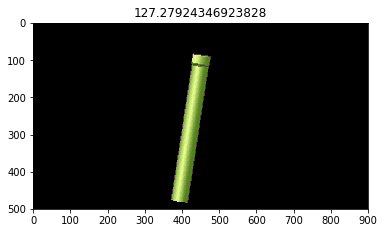

In [4]:
try:
    blcer2 = torch.load("../models/newBalancer.mdl")
except:
    print("No such model file to load...")

fig = plt.figure()
axe = fig.add_subplot(111)
dat = np.zeros((sy, sx))
img = axe.imshow(dat)

def illusnet(game,blcmdl):
    stat = game.getState()
    # print(stat)
    stat = Variable(torch.Tensor(stat))
    q_s = blcmdl(stat)
    # print(torch.max(q_s,0))
    a = torch.max(q_s,0)[1].data[0]
    q_action = q_s.data[a]
    vd = vdlist[a]
    # print(stat.data.numpy(),vd)
    stat, label, one_frame= game.forward(vd,disp=1)
    if label == 0:
        game.gameinit()
    ##
    IPython.display.clear_output(wait = True)
    img.set_data(np.transpose(one_frame,(1,0,2)))
    img.autoscale()
    axe.set_title(q_action)
    IPython.display.display(fig)
##

game.gameinit()
for i in range(1000):
    illusnet(game, blcer2)
    